In [18]:
import lightgbm as lgb
from sklearn import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

#from top scoring kernels and blends - for testing only
sub1 = pd.read_csv('input/best-ensemble-score-made-available-0-68/SHAZ13_ENS_LEAKS.csv')
sub2 = pd.read_csv('input/best-ensemble-score-made-available-0-67/SHAZ13_ENS_LEAKS.csv')
sub3 = pd.read_csv('input/feature-scoring-vs-zeros/leaky_submission.csv')

#standard
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
print(train.shape, test.shape)

(4459, 4993) (49342, 4992)


In [19]:
col = [c for c in train.columns if c not in ['ID', 'target']]
xtrain = train[col].copy().values
target = train['target'].values

leak_col = []
for c in col:
    leak1 = np.sum((train[c]==train['target']).astype(int))
    leak2 = np.sum((((train[c] - train['target']) / train['target']) < 0.05).astype(int))
    if leak1 > 30 and leak2 > 3500:
        leak_col.append(c)
        
print(len(leak_col))
print(leak_col)

51
['20aa07010', '87ffda550', '963a49cdc', '63c094ba4', '26fc93eb7', '0572565c2', '66ace2992', 'fb49e4212', '6619d81fc', '6eef030c1', 'fc99f9426', '1c71183bb', 'df838756c', 'b43a7cfd5', '024c577b9', '2ec5b290f', '44d5b820f', '0ff32eb98', '58e056e12', '241f0f867', '1931ccfdd', '58e2e02e6', '9fd594eec', 'fb0f5dbfe', 'd5fa73ead', 'f6eba969e', '91f701ba2', '8e4d0fe45', '703885424', '6c5c8869c', '2e103d632', '122c135ed', 'eeb9cd3aa', '324921c7b', '58232a6fb', '491b9ee45', 'd6bb78916', '70feb1494', 'adb64ff71', '62e59a501', '15ace8c9f', '5c6487af1', 'f190486d6', 'f74e8f13d', 'c5a231d81', 'e176a204a', '1702b5bf0', '190db8488', 'c47340d97', '6df033973', '23310aa6f']


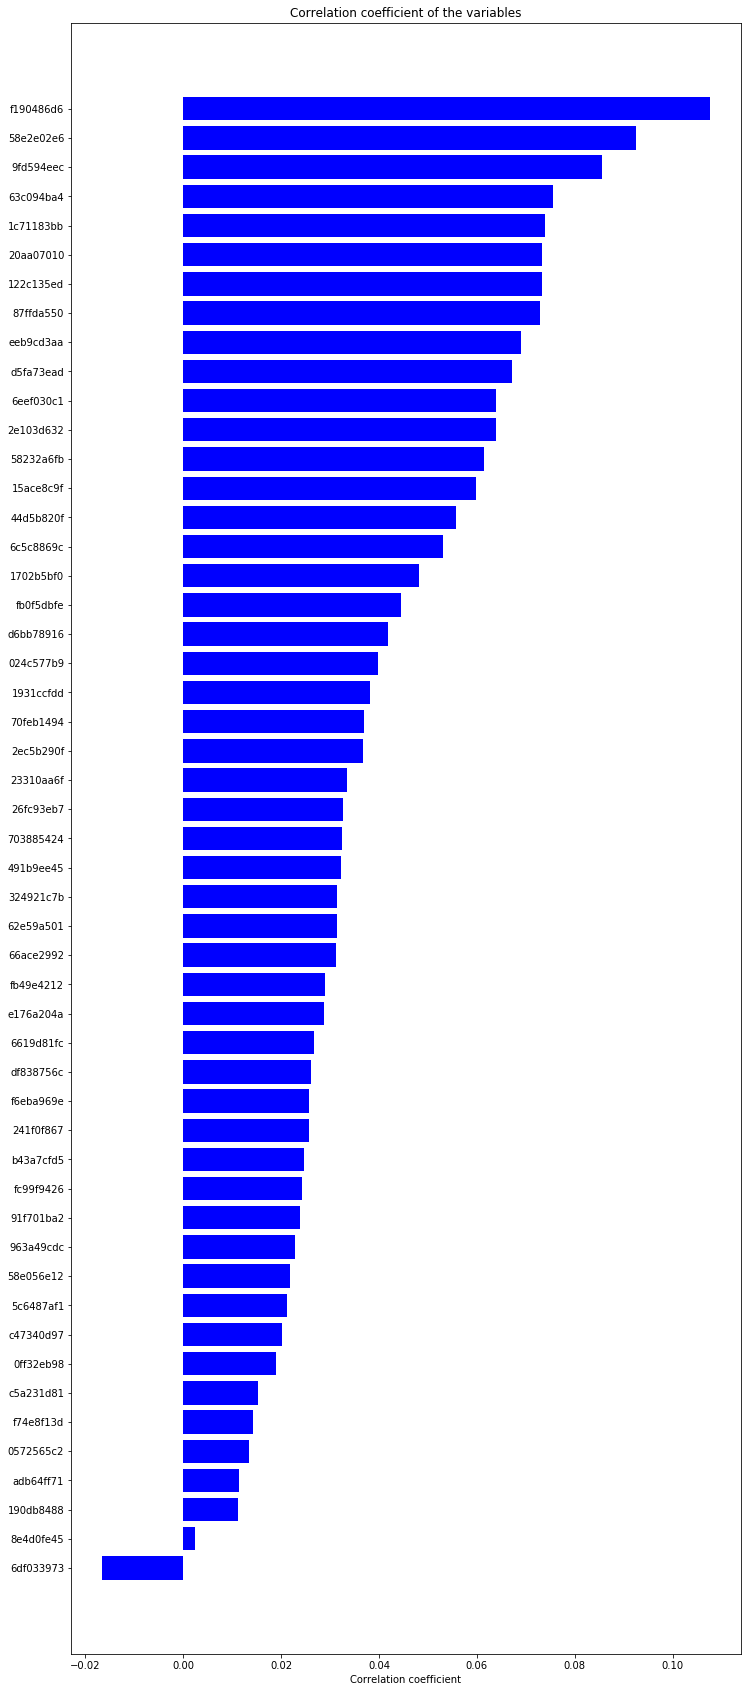

In [20]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []
for col in leak_col:
    labels.append(col)
    values.append(spearmanr(train[col].values, train["target"].values)[0])
    
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

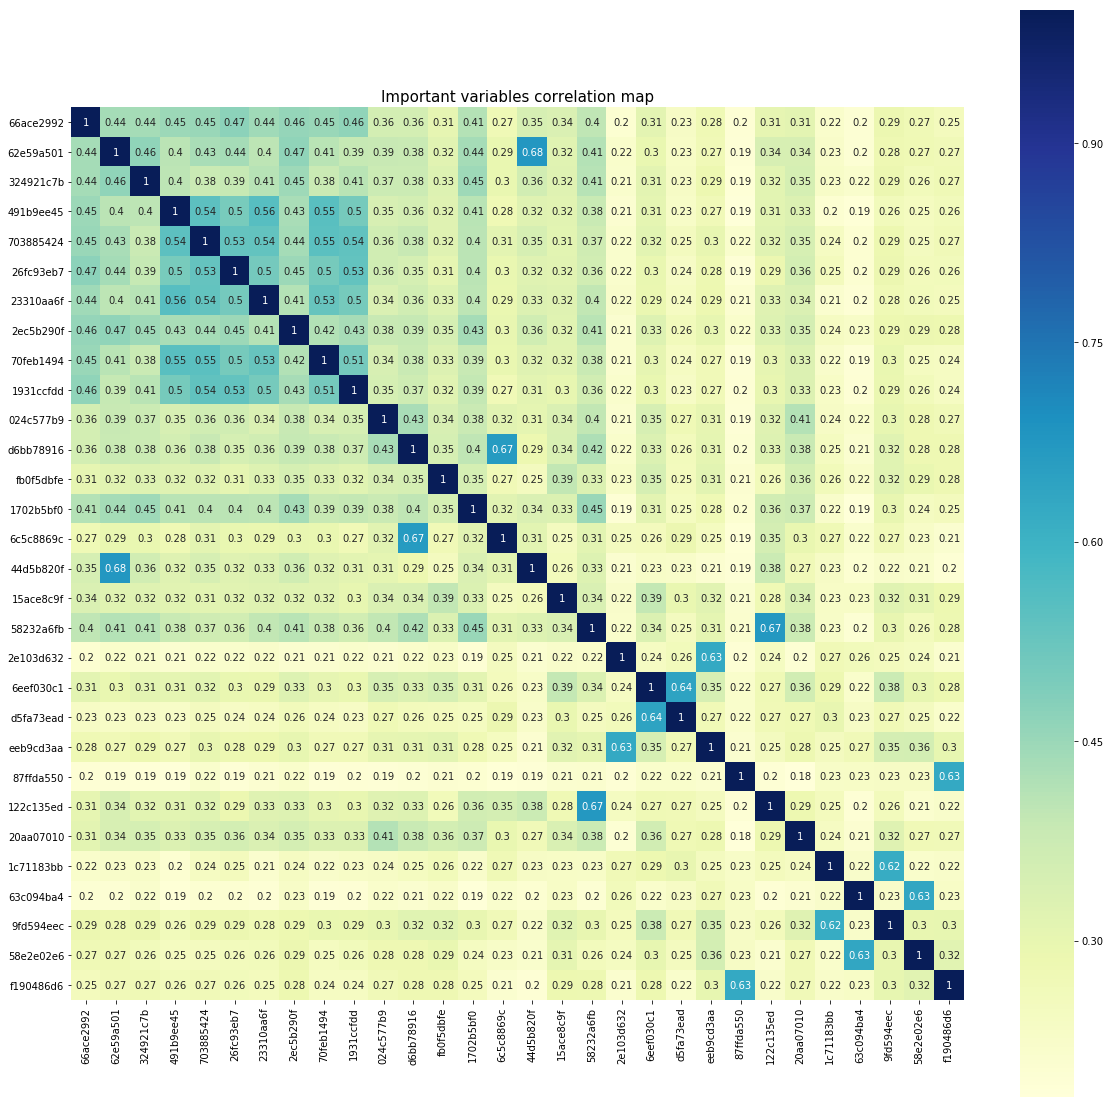

In [24]:
cols_to_use = corr_df[(corr_df['corr_values']>0.03) | (corr_df['corr_values']<-0.03)].col_labels.tolist()

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [93]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [94]:
# define base model
def baseline_model(activation="relu", optimizer="adam", dropout=0.2):
    # create model
    model = Sequential()
    model.add(Dense(units=51, input_dim=51, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=25, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    # Compile model
    model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
    return model

In [96]:
activation = ["relu", "sigmoid"]
optimizer = ["adam", "adagrad", 'SGD', 'RMSprop']
dropout = [0.2, 0.4, 0.5]
epochs = [10, 25]
batch_size = [5, 10]

In [97]:
# Retrieve model and parameter into GridSearchCV
estimator = KerasRegressor(build_fn=baseline_model, verbose=0)
param_grid = dict(activation=activation, 
                  optimizer=optimizer,
                  dropout=dropout,
                  epochs=epochs,
                  batch_size=batch_size)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid)

# Run grid search
grid_result = grid.fit(train[leak_col], train["target"])

print (grid_result.best_score_)
print (grid_result.best_params_)

-4.68204015909115
{'activation': 'relu', 'batch_size': 5, 'dropout': 0.2, 'epochs': 25, 'optimizer': 'RMSprop'}


In [98]:
# Tuned model
def tuned_model(activation="relu", optimizer="RMSprop", dropout=0.2):
    # create model
    model = Sequential()
    model.add(Dense(units=51, input_dim=51, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=25, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    # Compile model
    model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
    return model

In [99]:
estimator = KerasRegressor(build_fn=tuned_model, epochs=25, batch_size=5, verbose=0)

kfold = KFold(n_splits=10)
results = cross_val_score(estimator, train[leak_col], train["target"], cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -3.97 (0.43) MSE


In [104]:
model = tuned_model()
model.fit(train[leak_col], train["target"], epochs=25, batch_size=5, verbose=0)

In [107]:
test["target"] = model.predict(test[leak_col])

In [113]:
test[['ID', 'target']].to_csv('submission.csv', index=False)